In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.time_series import *
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from statsmodels.tsa.deterministic import Fourier

# Load data
df = pd.read_csv("CSV\export-jsps018-1h.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], format="mixed")
df.set_index("timestamp", inplace=True)

# Keep only the last 1 year of data
one_year_ago = df.index.max() - pd.DateOffset(years=2)
df = df[df.index >= one_year_ago]

# Drop unnecessary columns
df.drop(columns=["timezone", "Unnamed: 0", "pm_2_5_sp","location" ,"pm_10"], inplace=True, errors="ignore")

# Resample to hourly and fill missing values

# Remove outliers using IQR
Q1 = df["pm_2_5"].quantile(0.25)
Q3 = df["pm_2_5"].quantile(0.75)
IQR = Q3 - Q1
df = df[(df["pm_2_5"] >= Q1 - 1.5 * IQR) & (df["pm_2_5"] <= Q3 + 1.5 * IQR)]

Q1t = df["temperature"].quantile(0.25)
Q3t = df["temperature"].quantile(0.75)
IQRt = Q3t - Q1t
df = df[(df["temperature"] >= Q1t - 1.5 * IQRt) & (df["temperature"] <= Q3t + 1.5 * IQRt)]

Q1h = df["humidity"].quantile(0.25)
Q3h = df["humidity"].quantile(0.75)
IQRh = Q3h - Q1h
df = df[(df["humidity"] >= Q1h - 1.5 * IQRh) & (df["humidity"] <= Q3h + 1.5 * IQRh)]
print(df)
df.interpolate(method="linear", inplace=True)

df = df.resample("D").mean().fillna(method="ffill")

# ✅ ปรับขนาดข้อมูลเป็น 4 ช่วงต่อวัน (ทุก 6 ชั่วโมง)
df = df.resample("D").mean()

# ✅ Fourier Terms (Weekly Seasonality) สำหรับ 4 ช่วงต่อวัน
fourier = Fourier(
    period=7, order=2
)  # Weekly seasonality with lower order (4 periods/day × 7 days)
fourier_features = fourier.in_sample(df.index)
df = pd.concat([df, fourier_features], axis=1)
df.dropna(inplace=True)

# ✅ เพิ่ม Lag Features หลายระดับ (Short-Term & Long-Term) สำหรับ 4 ช่วงต่อวัน
for lag in [
    7 +1,
    7 + 3,
    7 + 7,
    7 + 14,
]:  # 1 วัน, 2 วัน, 3 วัน, 7 วัน, 14 วัน (ปรับสเกลเป็น 4 ช่วงต่อวัน)
    df[f"pm_2_5_lag{lag}"] = df["pm_2_5"].shift(lag)
    df[f"humidity_lag{lag}"] = df["humidity"].shift(lag)
    df[f"temperature_lag{lag}"] = df["temperature"].shift(lag)

# ✅ เพิ่ม Rolling Mean และ Rolling Std หลายระดับ
for window in [2, 3, 5,7,14]:  # 1 วัน, 3 วัน, 7 วัน, 14 วัน (ปรับสเกลเป็น 4 ช่วงต่อวัน)
    df[f"pm_2_5_rollmean{window}"] = (
        df["pm_2_5"].shift(7).rolling(window=window, min_periods=1).mean()
    )
    df[f"pm_2_5_rollstd{window}"] = (
        df["pm_2_5"].shift(7).rolling(window=window, min_periods=1).std()
    )
    # df[f"temperature_rollmean{window}"] = (
    #     df["temperature"].shift(7).rolling(window=window, min_periods=1).mean()
    # )
    # df[f"temperature_rollstd{window}"] = (
    #     df["temperature"].shift(7).rolling(window=window, min_periods=1).std()
    # )
    df[f"humidity_rollmean{window}"] = (
        df["humidity"].shift(7).rolling(window=window, min_periods=1).mean()
    )
    df[f"humidity_rollstd{window}"] = (
        df["humidity"].shift(7).rolling(window=window, min_periods=1).std()
    )
    df[f"temperature_rollmean{window}"] = (
        df["temperature"].shift(7).rolling(window=window, min_periods=1).mean()
    )
    df[f"temperature_rollstd{window}"] = (
        df["temperature"].shift(7).rolling(window=window, min_periods=1).std()
    )

df = df.drop(columns=["temperature","humidity"])
df = df.asfreq("D").fillna(method="bfill")  # เติมข้อมูลก่อนแบ่ง


# แบ่งข้อมูลสำหรับฝึกและทดสอบ (7 วัน = 28 ช่วง)
train = df.iloc[:-7]  # แบ่ง train
test = df.iloc[-7:]  # แบ่ง test

# ✅ เลือกเฉพาะฟีเจอร์ที่สำคัญ
selected_features = ["pm_2_5"] + [col for col in df.columns if col != "pm_2_5"]
train = train[selected_features]
test = test[selected_features]

                      humidity     pm_2_5  temperature
timestamp                                             
2023-02-11 00:00:00  69.658202  12.141667    28.784570
2023-02-11 01:00:00  60.327300  15.250000    28.571918
2023-02-11 02:00:00  64.339689  13.741667    28.634442
2023-02-11 03:00:00  66.888631  11.175000    28.762091
2023-02-11 04:00:00  63.175217  11.876033    28.556183
...                        ...        ...          ...
2025-02-10 20:00:00  74.448023  21.883333    27.581758
2025-02-10 21:00:00  75.690356  22.533333    27.272161
2025-02-10 22:00:00  76.548315  20.416667    27.075584
2025-02-10 23:00:00  77.615025  23.000000    26.824631
2025-02-11 00:00:00  79.342565  25.750000    26.414927

[15861 rows x 3 columns]


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\logging\__init__.py", line 1103, in emit
    stream.write(msg + self.terminator)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
UnicodeEncodeError: 'charmap' codec can't encode characters in position 292-309: character maps to <undefined>
Call stack:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\aufaw_nq8olti\Work\term

In [2]:
train


,pm_2_5,"sin(1,7)","cos(1,7)","sin(2,7)","cos(2,7)",pm_2_5_lag8,humidity_lag8,temperature_lag8,pm_2_5_lag10,humidity_lag10,...,humidity_rollmean7,humidity_rollstd7,temperature_rollmean7,temperature_rollstd7,pm_2_5_rollmean14,pm_2_5_rollstd14,humidity_rollmean14,humidity_rollstd14,temperature_rollmean14,temperature_rollstd14
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-02-11,8.685419,0.000000e+00,1.000000,0.000000e+00,1.000000,8.685419,57.811133,28.904058,8.685419,57.811133,...,57.811133,0.705067,28.904058,0.329375,8.685419,2.521639,57.811133,0.705067,28.904058,0.329375
2023-02-12,12.251554,7.818315e-01,0.623490,9.749279e-01,-0.222521,8.685419,57.811133,28.904058,8.685419,57.811133,...,57.811133,0.705067,28.904058,0.329375,8.685419,2.521639,57.811133,0.705067,28.904058,0.329375
2023-02-13,17.542540,9.749279e-01,-0.222521,-4.338837e-01,-0.900969,8.685419,57.811133,28.904058,8.685419,57.811133,...,57.811133,0.705067,28.904058,0.329375,8.685419,2.521639,57.811133,0.705067,28.904058,0.329375
2023-02-14,18.278837,4.338837e-01,-0.900969,-7.818315e-01,0.623490,8.685419,57.811133,28.904058,8.685419,57.811133,...,57.811133,0.705067,28.904058,0.329375,8.685419,2.521639,57.811133,0.705067,28.904058,0.329375
2023-02-15,9.554856,-4.338837e-01,-0.900969,7.818315e-01,0.623490,8.685419,57.811133,28.904058,8.685419,57.811133,...,57.811133,0.705067,28.904058,0.329375,8.685419,2.521639,57.811133,0.705067,28.904058,0.329375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,23.975235,-7.818315e-01,0.623490,-9.749279e-01,-0.222521,32.955514,77.303945,27.565467,19.766532,77.228145,...,80.569003,5.159110,26.877400,0.950792,24.279920,10.927711,81.014934,4.498374,26.599428,0.896571
2025-02-01,31.486123,-6.075486e-14,1.000000,-1.215097e-13,1.000000,11.233774,85.265404,26.583507,33.141055,75.086787,...,80.283481,4.929023,27.073951,0.737325,24.107941,10.958449,81.085573,4.521420,26.648713,0.891156
2025-02-02,30.984870,7.818315e-01,0.623490,9.749279e-01,-0.222521,21.173920,82.910988,26.877862,32.955514,77.303945,...,79.165911,3.710110,27.346226,0.447952,23.033013,11.022894,81.174819,4.480775,26.723324,0.927810


In [3]:
# ✅ เพิ่ม fold เป็น 5 เพื่อให้โมเดล Generalize ขึ้น
experiment = setup(
    data=train,
    target="pm_2_5",
    session_id=123,
    use_gpu=True,
    fh=7,  # Forecast horizon = 7 days (28 periods)
    fold=2,
    seasonal_period="D",
    verbose=True,
)
test.index = test.index.to_period("D")

# ✅ ลองโมเดล ARIMA ก่อน
arima_model = create_model("arima")
arima_model = tune_model(arima_model)
final_arima = finalize_model(arima_model)

# Predict using the finalized model
X_forecast = test.drop(columns=["pm_2_5"])

,Description,Value
0,session_id,123
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(725, 47)"
5,Transformed data shape,"(725, 47)"
6,Transformed train set shape,"(718, 47)"
7,Transformed test set shape,"(7, 47)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there a

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-01-14,1.5227,1.4252,12.3517,14.9094,1.5131,0.5987,-1.0557
1,2025-01-21,1.2434,1.1486,10.1645,12.1363,0.7344,0.4791,-0.7901
Mean,NaT,1.3831,1.2869,11.2581,13.5228,1.1238,0.5389,-0.9229
SD,NaT,0.1396,0.1383,1.0936,1.3865,0.3894,0.0598,0.1328


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-01-14,2.0701,1.9377,16.7923,20.2714,2.0408,0.6903,-2.8002
1,2025-01-21,1.0941,1.0210,8.9437,10.7885,0.4629,0.4481,-0.4146
Mean,NaT,1.5821,1.4794,12.8680,15.5299,1.2518,0.5692,-1.6074
SD,NaT,0.4880,0.4583,3.9243,4.7414,0.7890,0.1211,1.1928


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   30.4s remaining:   30.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.1min finished


MAE: 4.18
MAPE: 27.31%
R2: -0.30
accurent: 72.69


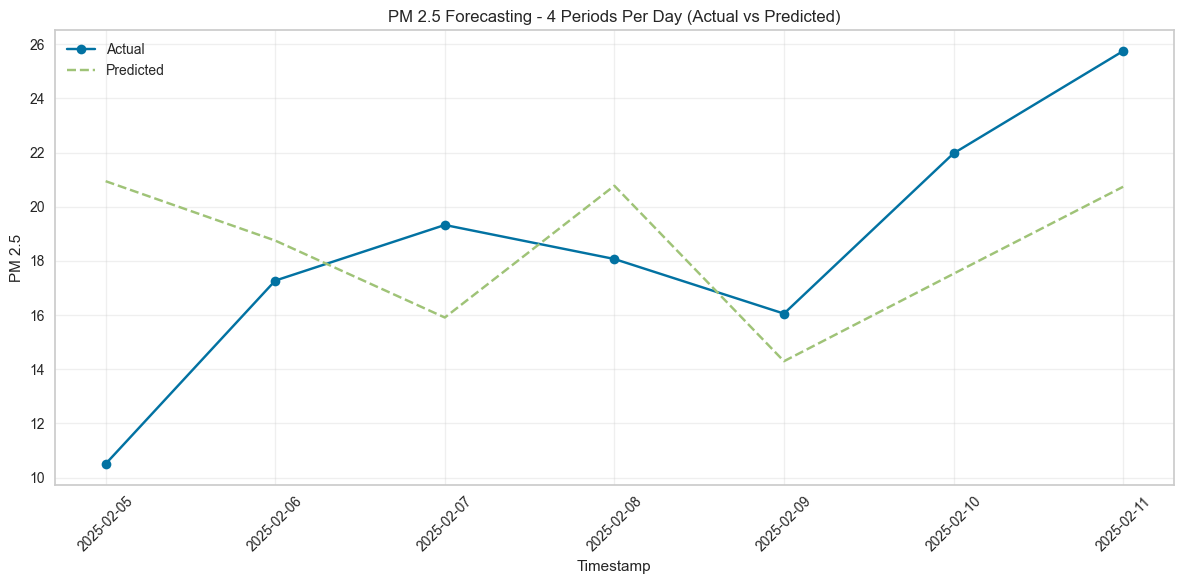

In [4]:
predictions = predict_model(final_arima, X=X_forecast)

# Evaluate Performance
mae = mean_absolute_error(test["pm_2_5"], predictions)
mape = mean_absolute_percentage_error(test["pm_2_5"], predictions) * 100
r2 = r2_score(test["pm_2_5"], predictions)
accurent = 100 - mape

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2: {r2:.2f}")
print(f"accurent: {accurent:.2f}")

# ✅ แปลง Index ของ test ให้เป็น Timestamp ก่อนทำการ Plot
plt.figure(figsize=(12, 6))
plt.plot(
    test["pm_2_5"].index.to_timestamp(), test["pm_2_5"], label="Actual", marker="o"
)
plt.plot(
    test["pm_2_5"].index.to_timestamp(),
    predictions,
    label="Predicted",
    linestyle="--",
    marker="x",
)
plt.title("PM 2.5 Forecasting - 4 Periods Per Day (Actual vs Predicted)")
plt.xlabel("Timestamp")
plt.ylabel("PM 2.5")
plt.legend()
plt.grid(True, alpha=0.3)

# เพิ่มการแสดงช่วงเวลาให้ชัดเจนขึ้น
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
save_model(final_arima, "jsps018")

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 ARIMA(seasonal_order=(0,
                                                                                                                                                       1,
                                                                                                                                                       0,
                                                                                                                                                       7)))]))]))]))]),
 'jsps01

In [ ]:
X_forecast.to_csv("jsps018_predic.csv")

: 